### Jake's EDA

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# below imports are for visualization purposes
import plotly.express as px
import plotly.graph_objects
from sklearn.svm import SVR

#### Loading in the data and then taking a look around

In [2]:
df = pd.read_csv("../../../data/kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

#### There's a handful of null values in waterfront, yr_renovated, and view

For now I'm not really worried about interacting with these three, so I'm going to replace these nulls with zeros

In [4]:
# running a describe to see how it changes my summary stats
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [23]:
df["waterfront"].fillna("0", inplace = True)
df["view"].fillna("0", inplace = True)
df["yr_renovated"].fillna("0", inplace = True)

# I noticed that using the above code changed the columns to objects and so they weren't showing up in the df.describe() below.
df["waterfront"] = df["waterfront"].astype("float64")
df["view"] = df["view"].astype("float64")
df["yr_renovated"] = df["yr_renovated"].astype("float64")

# later noticed that sqft_basement was an object instead of float so I'm going to change that as well
# sqft_basement has  454 ? as a placeholder value, so we're going to replace that with 0 (which is already over half of values)
df["sqft_basement"] = df["sqft_basement"].replace("?", "0")
df["sqft_basement"] = df["sqft_basement"].astype("float64")

# changing date from an object to a datetime
df["date"] = df["date"].astype("datetime64")

# feature engineering a month sold and year sold column from date
df["year_sold"] = pd.DatetimeIndex(df['date']).year
df["year_sold"] = df["year_sold"].astype("float64")

df["month_sold"] = pd.DatetimeIndex(df["date"]).month
df["month_sold"] = df["month_sold"].astype("float64")

In [24]:
# second describe and sanity check
display(df.describe(), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     21597 non-null  float64       
 9   view           21597 non-null  float64       
 10  condition      21597 non-null  int64         
 11  grade          21597 non-null  int64         
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  float64       
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   2159

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,...,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.006760,0.233181,3.409825,...,285.716581,1970.999676,68.758207,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,2014.322962,6.573969
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.081944,0.764673,0.650546,...,439.819830,29.375234,364.037499,53.513072,0.138552,0.140724,685.230472,27274.441950,0.467619,3.115061
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,...,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,2014.000000,1.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,...,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,2014.000000,4.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,...,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,2014.000000,6.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,...,550.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,2015.000000,9.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,...,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,2015.000000,12.000000


None

#### Now that that's done it's time to do a quick correlation check for all the features.  I use a .corr() instead of a heatmap because the plain numbers are easier to understand with this many interactions

In [25]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.003599,0.011772,-0.023803,...,-0.004359,0.021617,-0.010612,-0.008211,-0.001798,0.020672,-0.002701,-0.138557,0.009915,-0.011572
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.264306,0.393497,0.036056,...,0.321108,0.053953,0.117855,-0.053402,0.306692,0.022036,0.585241,0.082845,0.003727,-0.009928
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002127,0.078354,0.026496,...,0.297229,0.155670,0.017900,-0.154092,-0.009951,0.132054,0.393406,0.030690,-0.009949,-0.001046
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.063629,0.186016,-0.126479,...,0.278485,0.507173,0.047177,-0.204786,0.024280,0.224903,0.569884,0.088303,-0.026577,0.007543
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.104637,0.281715,-0.059445,...,0.428660,0.318152,0.051060,-0.199802,0.052155,0.241214,0.756402,0.184342,-0.029014,0.012112
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.021459,0.075054,-0.008830,...,0.015031,0.052946,0.004979,-0.129586,-0.085514,0.230227,0.144763,0.718204,0.005628,-0.002591
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.020797,0.028414,-0.264075,...,-0.241866,0.489193,0.003793,-0.059541,0.049239,0.125943,0.280102,-0.010722,-0.022352,0.014245
waterfront,-0.003599,0.264306,-0.002127,0.063629,0.104637,0.021459,0.020797,1.000000,0.380543,0.016648,...,0.083050,-0.024487,0.073939,0.028923,-0.012157,-0.037628,0.083823,0.030658,-0.005018,0.008199
view,0.011772,0.393497,0.078354,0.186016,0.281715,0.075054,0.028414,0.380543,1.000000,0.045622,...,0.270629,-0.054452,0.090339,0.085059,0.006321,-0.077702,0.278928,0.073083,0.001239,-0.005161
condition,-0.023803,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.016648,0.045622,1.000000,...,0.168482,-0.361592,-0.055808,0.002888,-0.015102,-0.105877,-0.093072,-0.003126,-0.045898,0.022388


#### 3 most correlated to our target (price) are sqft living, grade, sqft above.  The house sqft info (living, above, basement) all seem like redundant info, so I'll be replacing sqft above with sqft_living15 and bathrooms


bedrooms, floors, waterfront, view, condition, and lat all have some level of impact as well

#### Below I'm creating the first model, and raising grade to the 4th due to a graphical observation made in Lorin's work.

Taking advice from Elliott, I'll be train test splitting my training data as well in order to create a test data set that wont be touched until the end of model prep.

In [8]:
X = df[["sqft_living", "sqft_living15", "bathrooms"]]
X["grade_sq"] = df["grade"]**4

y = df[["price"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, random_state=42)

<ipython-input-8-78d8840b3bfe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["grade_sq"] = df["grade"]**4


In [9]:
model = LinearRegression()
model.fit(X_train2, y_train2)

predict_train = model.predict(X_train2)
predict_test = model.predict(X_test2)

print('Training r2:', (r2_score(y_train2, predict_train)))
print('Test r2:', (r2_score(y_test2, predict_test)))
print("RMSE: ", (np.sqrt(mean_squared_error(y_test2, predict_test))))

Training r2: 0.5815897141340844
Test r2: 0.554924102381855
RMSE:  230116.6521183616


#### The below cell was changed loads of times as the group was mixing and matching various features to see what was working and what wasn't.

Adding yr_built (although it has a very low correlation coefficient with price) seemed to really improve the model.  Things like bedrooms, and yr_renovated seemed to have no real effect.

In [36]:
X = df[["sqft_living", "sqft_living15", "bathrooms", "yr_built", "lat", "condition", "year_sold", "month_sold", "view"]]
X["grade_sq"] = df["grade"]**4

y = df[["price"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, random_state=42)


model.fit(X_train2, y_train2)

predict_train = model.predict(X_train2)
predict_test = model.predict(X_test2)

print('Training r2:', (r2_score(y_train2, predict_train)))
print('Test r2:', (r2_score(y_test2, predict_test)))
print("RMSE: ", (np.sqrt(mean_squared_error(y_test2, predict_test))))

Training r2: 0.7067678463061675
Test r2: 0.6970536069562236
RMSE:  189851.44274499014


<ipython-input-36-b23fe0996a6d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["grade_sq"] = df["grade"]**4


#### Was reviewing some lecture notes and doing some research on creating linear models and found PolynomialFeatures so I figured I'd give it a try

In [37]:
poly = PolynomialFeatures(include_bias=False)

poly_train = poly.fit_transform(X_train2)
poly_test = poly.fit_transform(X_test2)

polymodel = LinearRegression()

polymodel.fit(poly_train, y_train2)

polypredict = polymodel.predict(poly_test)
print(r2_score(y_test2, polypredict))
print("RMSE: ", (np.sqrt(mean_squared_error(y_test2, polypredict))))

0.7429849674857794
RMSE:  174867.97124728005


#### So this performs a lot better than the model before it, and gets us closer to the desired .75.

I need to do more research on my own to figure out exactly what PolynomialFeatures does so I can understand it, but this seems like a decent place to start working on other things.

#### I'm going to start making visuals for both my own understanding and potentially presentation material.

Don't forget that really cool linear regression plot you made in project 1 using seaborn

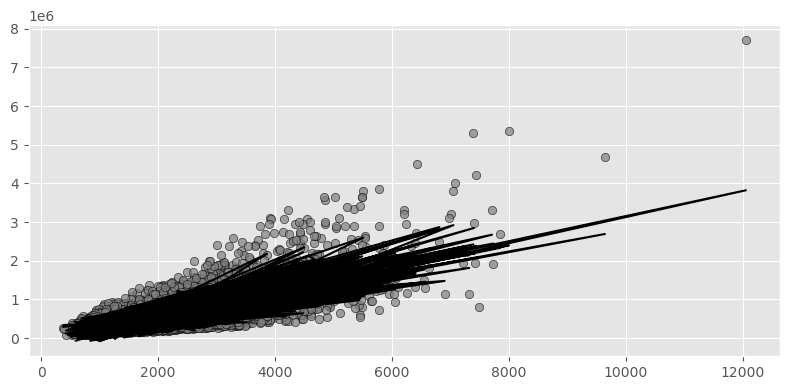

In [12]:
plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(X_train2.sqft_living, model.predict(X_train2), color='k')
ax.scatter(X_train2.sqft_living, y_train2, edgecolor='k', facecolor='grey', alpha=0.7)


fig.tight_layout()

Took me a while to figure it out but this graph happens because I'm trying to plot a multiple linear regression on 2d graph.


#### Below I'm going to start making some 3d visuals using plotly for our presentation

In [13]:
mesh_size = 0.02
margin = 0

In [14]:
graph_X = X_train2[["sqft_living", "sqft_living15"]]
graph_y = y_train2["price"]

graph_model = SVR(C=1.)
graph_model.fit(graph_X, graph_y)

x_min, x_max = graph_X.sqft_living.min(), graph_X.sqft_living.max()
y_min, y_max = graph_y.min(), graph_y.max()

xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)
xx, yy = np.meshgrid(xrange, yrange)

graph_pred = graph_model.predict(np.c_[xx.ravel(), yy.ravel()])
graph_pred = graph_pred.reshape(xx.shape)

fig = px.scatter_3d(df, x="sqft_living", y="price", z="sqft_living15")
fig.update_traces(marker=dict(size=5))
fig.add_traces(go.Surface(x=xrange, y=yrange, z=pred, name='pred_surface'))
fig.show()

MemoryError: Unable to allocate 1.58 PiB for an array with shape (381100000, 584000) and data type float64

#### Obvious memory issue here, gonna have to investigate this later.  Really bummed.

Only thing I can think of is that I'm using way too many rows from the data and will need to trim it down.  Probably it because the documentation example only uses a dataset of 150 entries.

In [ ]:
iris = px.data.iris()
iris.info()